# Cokriging from maximum likelihood estimates over continental US

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import krige_tools
import fields
import variogram as vgm
import cov_model
import cokrige

In [4]:
# Analysis variables
timestamp = "2019-08-01"
timedelta = -1

# Variogram settings
bin_centers = np.linspace(0, 4.5e3, 20)
tol = 250

# Initial guess for covariance params
cov_guess = [0.5, 1e3, 0.1]
cross_guess = [1e3, -0.1]

In [5]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly_conus.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, standardize_window=True, fast_dist=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


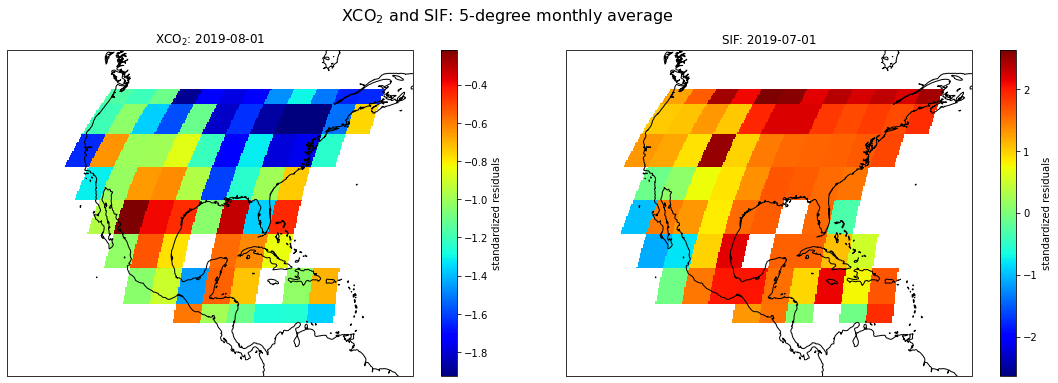

In [6]:
# Plot the data being used for cokriging
# NOTE: figures should share a color bar, but we just want a quick look
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 50]

fig.suptitle(
    "XCO$_2$ and SIF: 5-degree monthly average", 
    size=16, y=0.98
)

# Input data
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())

xr.plot.imshow(
        darray=mf.field_1.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
        cbar_kwargs={"label": "standardized residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title(f"XCO$_2$: {mf.field_1.timestamp}")

xr.plot.imshow(
        darray=mf.field_2.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
        cbar_kwargs={"label": "standardized residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: {mf.field_2.timestamp}");

In [7]:
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, params = model.empirical_variograms(bin_centers, tol, cov_guess, cross_guess)
# predictor = cokrige.Cokrige(mf, model, fast_dist=True)

In [8]:
params

{'xco2': array([6.40000384e-01, 1.70865688e+03, 1.27107620e-01]),
 'sif': array([8.74560432e-01, 1.00483456e+03, 2.61865867e-01]),
 'xco2:sif_back': array([ 4.e+03, -1.e+00]),
 'xco2:sif_forward': array([ 4.e+03, -1.e+00])}

In [9]:
model.get_params()

{'sigma_11': 1.0,
 'len_scale_11': 1.0,
 'nugget_11': 0.0,
 'len_scale_12': 1.0,
 'rho': 0.0,
 'sigma_22': 1.0,
 'len_scale_22': 1.0,
 'nugget_22': 0.0}

In [10]:
names = [mf.field_1.data_name, "", mf.field_2.data_name]
names[1] = f"{names[0]}:{names[2]}_back"

guess = np.hstack([params[name] for name in names])
guess

array([ 6.40000384e-01,  1.70865688e+03,  1.27107620e-01,  4.00000000e+03,
       -1.00000000e+00,  8.74560432e-01,  1.00483456e+03,  2.61865867e-01])

In [11]:
# guess = list(model.get_params().values())
guess[3] = 1600.0
guess[4] = -0.7
# guess = [2.2, 1700.0, 0.1, 500.0, -0.6, 0.4, 1200.0, 0.1]
model.fit(initial_guess=guess)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [12]:
print(model.get_params())
mle_params = list(model.get_params().values())
mle_params

{'sigma_11': 1.3921392825248424, 'len_scale_11': 1708.6915126089314, 'nugget_11': 0.0, 'len_scale_12': 1599.944816683113, 'rho': -0.6158089488118929, 'sigma_22': 0.2, 'len_scale_22': 1004.8904212124494, 'nugget_22': 0.0}


[1.3921392825248424,
 1708.6915126089314,
 0.0,
 1599.944816683113,
 -0.6158089488118929,
 0.2,
 1004.8904212124494,
 0.0]

In [13]:
vario_res["xco2"]["mle_fit"] = vgm.matern_vario(vario_res["xco2"]["lag"], *mle_params[:3])
vario_res["xco2:sif_back"]["mle_fit"] = vgm.matern_cross_cov(vario_res["xco2:sif_back"]["lag"], [mle_params[0], mle_params[5]], *mle_params[3:5])
vario_res["sif"]["mle_fit"] = vgm.matern_vario(vario_res["sif"]["lag"], *mle_params[5:])

Text(0.5, 0.98, 'Variograms and cross-covariograms for XCO$_2$ and SIF residuals\nContinental US, 2019-08-01, locally detrended and standardized, spatial tolerance: 250 km')

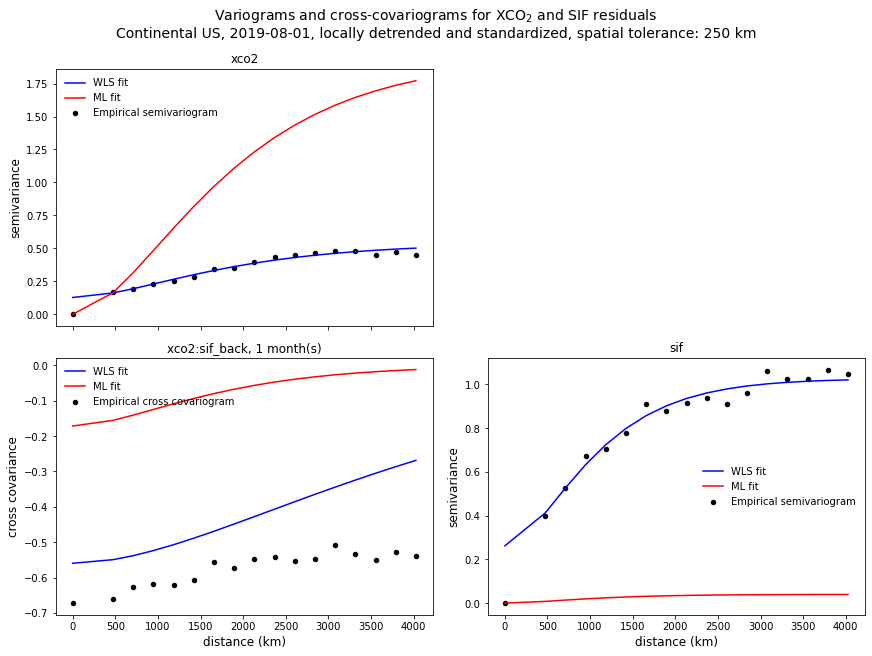

In [15]:
var_names = ["xco2", "sif"]
cross_names = ["xco2:sif_back"]

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
    df.plot(x="lag", y="wls_fit", kind="line", color="blue", ax=ax[i, i], label="WLS fit")
    df.plot(x="lag", y="mle_fit", kind="line", color="red", ax=ax[i, i], label="ML fit")
    lim = df[var].max()
#     ax[i, i].set_ylim([0, lim+0.1*lim])
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("semivariance", fontsize=12)
    ax[i, i].set_xlabel("distance (km)", fontsize=12)
#     ax[i, i].text(0.95, 0.05, param_labels(params_fit[var]), transform=ax[i, i].transAxes, ha="right", va="bottom")
    ax[i, i].legend(frameon=False)

for i, cross in enumerate(cross_names):
    df = vario_res[cross]
    df.plot(x="lag", y="xco2:sif", kind="scatter", color="black", ax=ax[1-i, i], label="Empirical cross covariogram")
    df.plot(x="lag", y="wls_fit", kind="line", color="blue", ax=ax[1-i, i], label="WLS fit")
    ax[1-i, i].set_title(cross + f", {np.abs(timedelta)} month(s)", fontsize=12)
    if i == 0:
        df.plot(x="lag", y="mle_fit", kind="line", color="red", ax=ax[1-i, i], label="ML fit")
#         ax[1-i, i].text(0.95, 0.05, param_labels(params_fit[cross], cross=True), transform=ax[1-i, i].transAxes, ha="right", va="bottom")
        ax[1-i, i].legend(loc="upper left", frameon=False)
#     else:
#         ax[1-i, i].text(0.05, 0.05, param_labels(params_fit[cross], cross=True), transform=ax[1-i, i].transAxes, ha="left", va="bottom")
#         ax[1-i, i].legend(loc="upper right", frameon=False)
    ax[1-i, i].set_ylabel("cross covariance", fontsize=12)
    ax[1-i, i].set_xlabel("distance (km)", fontsize=12)

fig.suptitle("Variograms and cross-covariograms for XCO$_2$ and SIF residuals\n"+
             f"Continental US, {timestamp}, locally detrended and standardized, spatial tolerance: {tol} km", fontsize=14)

# fig.savefig(f"../plots/vario_analysis_conUS_{timestamp}_{np.abs(timedelta)}M_{tol}km.png", dpi=100);